# YAASS Dataset

#### The dataset below includes demographic information and multiple clinical measures taken in 2 populations: healthy controls and those at clinical high risk for psychosis.

#### Will be adding more controls and SCZ population; possibly genetic HR.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) # This is helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # This is useful for getting effect sizes from chi-square tests

/Users/elyssabarrick/Work/Expts/Code


array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex', 'reshape2',
       'effsize', 'lsmeans', 'estimability', 'lmerTest', 'lme4', 'Matrix',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='<U12')

In [38]:
raw_sh = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017.xlsx')
raw_sh['Gender'].replace(2, 'female', inplace=True)
raw_sh['Gender'].replace(1,'male', inplace=True)
pd.set_option('display.max_columns', 500)

raw_sz = pd.read_excel(path2data + 'SCORE_ Final Sample_2.xlsx')
raw_sz['Group'].replace(2, 'SZ', inplace=True)
raw_sz['Group'].replace(1,'HC', inplace=True)

# raw = pd.concat([raw_sz, raw_sh])

raw = raw_sh.append(raw_sz)

raw

,Age,COWAT_Animal,DIARY,DepAnx_PANSS,Digit_Symbol_Scaled,Disorganized_PANSS,Education,Emot_IQ,Emotion_Experiencing,Emotional_reasoning,Ethnicity,Excited_PANSS,GFS_Role,GFS_Social,Gender,Group,HVLT_Tscore_Trials,ID,IQ,IRI_EC,IRI_FS,IRI_PD,IRI_PT,IRI_Total,Letter_Num_Seq_Scaled,MATRICS,Managing_emotions,Negative_PANSS,NumberGroup,Other_PANSS,Perceiving_EmotionsSSB1,Positive_PANSS,SAS_SocialLeisure,SAS_Work,SCAN 1,SCAN 2,SIPS_Disorganized,SIPS_General,SIPS_Negative,SIPS_Positive,SS_B,SS_C,SS_D,SS_E,SS_F,SS_G,SS_H,SS_a,TotalPLE,TrailsA_Tscore,TrailsB_Tscore,Understanding_emotions,Using_emotionsSSB2,Yrs of Education,log_Emot_IQ,log_Emotion_Experiencing,log_Emotional_reasoning,log_GFS_Role,log_GFS_Social,log_IRI_EC,log_IRI_FS,log_IRI_PD,log_IRI_PT,log_IRI_Total,log_Managing_emotions,log_SAS_SocialLeisure,log_SAS_Work,log_Understanding_emotions
0,33,18.0,NaN,4.0,NaN,5.0,12,NaN,NaN,NaN,NaN,4.0,NaN,NaN,female,HC,39.0,26105,102.0,36.0,30.0,12.0,32.0,110.0,NaN,NaN,NaN,7.0,1.0,10.0,NaN,5.0,49.0,80.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.556303,1.477121,1.079181,1.505150,2.041393,NaN,1.690196,1.903090,NaN
1,22,37.0,NaN,4.0,15.0,5.0,16,111.605097,106.704198,111.004276,NaN,4.0,9.0,10.0,male,HC,48.0,26120,133.0,24.0,33.0,14.0,31.0,102.0,18.0,NaN,106.421008,7.0,1.0,10.0,100.104756,5.0,42.0,0.0,NaN,NaN,0.0,0.0,2.0,1.0,124.993787,109.684629,104.351949,111.300239,96.811400,102.900197,104.732502,92.275573,0.0,43.0,72.0,108.092162,111.993224,NaN,2.047684,2.028182,2.045340,0.954243,1.000000,1.380211,1.518514,1.146128,1.491362,2.008600,2.027027,1.623249,NaN,2.033794
2,19,17.0,NaN,4.0,16.0,5.0,14,98.740000,90.430000,109.250000,NaN,4.0,9.0,10.0,female,HC,NaN,26130,118.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,101.560000,7.0,1.0,10.0,100.290000,5.0,45.0,51.0,NaN,NaN,0.0,0.0,0.0,0.0,76.946287,110.152912,99.318697,87.280961,87.878911,108.458863,101.373239,142.935444,0.0,NaN,NaN,111.890000,80.410000,NaN,1.994493,1.956313,2.038421,0.954243,1.000000,NaN,NaN,NaN,NaN,NaN,2.006723,1.653213,1.707570,2.048791
3,24,29.0,NaN,4.0,NaN,5.0,17,101.930000,102.170000,98.220000,NaN,4.0,9.0,10.0,female,HC,65.0,26133,103.0,34.0,34.0,16.0,33.0,117.0,12.0,NaN,92.390000,7.0,1.0,10.0,112.490000,6.0,62.0,55.0,NaN,NaN,2.0,2.0,1.0,4.0,83.040486,97.818194,94.128201,109.019677,101.526393,112.078773,90.910849,110.362848,0.0,68.0,51.0,106.800000,89.910000,NaN,2.008302,2.009323,1.992200,0.954243,1.000000,1.531479,1.531479,1.204120,1.518514,2.068186,1.965625,1.792392,1.740363,2.028571
4,19,NaN,NaN,4.0,NaN,5.0,13,108.700000,120.120000,95.810000,NaN,4.0,9.0,9.0,male,HC,NaN,26137,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.490000,7.0,1.0,10.0,131.930000,5.0,45.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,119.176320,101.728865,91.471298,111.905737,94.864296,92.002647,98.220674,142.935444,0.0,NaN,NaN,95.710000,106.870000,NaN,2.036230,2.079615,1.981411,0.954243,0.954243,NaN,NaN,NaN,NaN,NaN,1.979958,1.653213,NaN,1.980957
5,28,19.0,NaN,4.0,6.0,5.0,18,96.030000,84.930000,113.180000,NaN,5.0,10.0,10.0,male,HC,42.0,26138,123.0,39.0,31.0,9.0,40.0,119.0,10.0,NaN,108.440000,7.0,1.0,10.0,82.740000,5.0,51.0,48.0,NaN,NaN,0.0,0.0,0.0,0.0,101.397049,102.617500,105.178980,110.159696,88.610963,112.078773,106.711408,62.488205,0.0,36.0,35.0,109.330000,93.020000,NaN,1.982407,1.929061,2.053770,1.000000,1.000000,1.591065,1.491362,0.954243,1.602060,2.075547,2.035190,1.707570,1.681241,2.038739
6,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male,HC,NaN,26172,115.0,30.0,29.0,20.0,25.0,104.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.477121,1.462398,1.301030,1.397940,2.017033,NaN,NaN,NaN,NaN
7,20,27.0,NaN,4.0,19.0,5.0,15,108.716897,105.694031,106.294636,NaN,4.0,10.0,10.0,male,HC,46.0,26173,138.0,30.0,31.0,11.0,35.0,107.0,18.0,NaN,102.101292,7.0,1.0,10.0,99.446692,5.0,53.0,67.0,NaN,NaN,0.0,0.0,0.0,0.0,103.061332,105.673873,99.928940,99.925355,114.110635,104.066207,101.373829,98.097

### Demographics

In [39]:
raw.groupby('Group')['ID'].nunique()

Group
HC    47
HR    27
SZ    24
Name: ID, dtype: int64

In [40]:
# Even split in HC group, more males in HR group-unsurprising given a younger sample

raw.groupby('Group')['Gender'].value_counts()

Group  Gender
HC     male      26
       female    21
HR     male      18
       female     9
SZ     male      15
       female     9
dtype: int64

Group       
HC     count    47.000000
       mean     28.872340
       std      10.884007
       min      18.000000
       25%      21.000000
       50%      24.000000
       75%      33.000000
       max      55.000000
HR     count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
SZ     count    24.000000
       mean     39.500000
       std      11.263639
       min      21.000000
       25%      30.750000
       50%      39.500000
       75%      45.000000
       max      64.000000
dtype: float64
Between group t-test on Age
t(72) = 3.30, p = 0.002


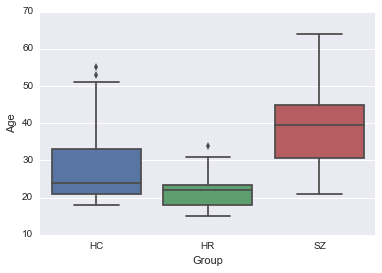

In [18]:
#Age
g=raw.groupby('Group')
print (g.Age.describe())

# print ('Between group t-test on Age')
# misc.ttest_2s(raw[raw.Group == 'HC']['Age'],raw[raw.Group == 'HR']['Age'],paired=False)

sns.boxplot(x='Group',y='Age',data=raw)

In [41]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group       
HC     count     47.000000
       mean     111.595745
       std       10.999327
       min       89.000000
       25%      103.500000
       50%      113.000000
       75%      118.000000
       max      138.000000
HR     count     24.000000
       mean     106.791667
       std       17.688068
       min       79.000000
       25%       91.750000
       50%      106.500000
       75%      122.250000
       max      139.000000
SZ     count     24.000000
       mean     107.041667
       std       15.685715
       min       70.000000
       25%       99.000000
       50%      108.000000
       75%      118.250000
       max      140.000000
dtype: float64


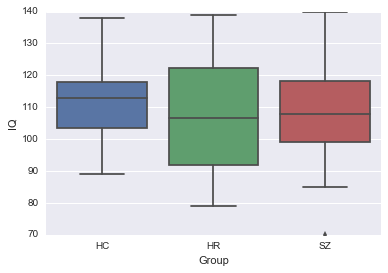

In [42]:
#IQ
i = raw_IQ.groupby('Group')

print (i.IQ.describe())
# print ('Between group t-test on IQ')
# misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'HR']['IQ'])

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

### Data Quality Check

In [48]:
"""Dataframe where any row that has NAN value is dropped- will tell us how many participants 
have at least some missing data"""
sh_no_na = raw_sh.dropna()

In [49]:
# looks like most participants have some missing values...
sh_no_na.groupby('Group')['ID'].nunique()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [50]:
"""Dataframe where any row that has less than 6 entries - which corresponds to anything other 
than demographic information/subject ID entered - are dropped. These are participants that 
should not be included in the analyses."""
df_cleaned = raw.dropna(thresh=6)

In [51]:
#one participant that has no measures taken: 26195
df_cleaned.groupby('Group')['ID'].nunique()

Group
HC    47
HR    26
SZ    24
Name: ID, dtype: int64